In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [7]:
# Load dataset
url = r"C:\Users\Verma\OneDrive\Desktop\Dataset\retail_sales_dataset.csv"

data = pd.read_csv(url)

# Display the first few rows of the dataset
data.head()


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [14]:
# Check for missing values
print(data.isnull().sum())

# Drop rows with missing values (if any)
data.dropna(inplace=True)

# Convert date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Remove duplicates
data.drop_duplicates(inplace=True)

# Ensure numeric columns are in the correct format
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')
data['Price per Unit'] = pd.to_numeric(data['Price per Unit'], errors='coerce')
data['Total Amount'] = pd.to_numeric(data['Total Amount'], errors='coerce')

# Summary of the cleaned data
print(data.info())


Transaction ID      0
Date                0
Customer ID         0
Gender              0
Age                 0
Product Category    0
Quantity            0
Price per Unit      0
Total Amount        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    1000 non-null   int64         
 1   Date              1000 non-null   datetime64[ns]
 2   Customer ID       1000 non-null   object        
 3   Gender            1000 non-null   object        
 4   Age               1000 non-null   int64         
 5   Product Category  1000 non-null   object        
 6   Quantity          1000 non-null   int64         
 7   Price per Unit    1000 non-null   int64         
 8   Total Amount      1000 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 70.4+ KB
None


In [15]:

# Descriptive statistics
print(data.describe())

# Sales by Date
daily_sales = data.groupby('Date')['Total Amount'].sum().reset_index()

# Sales by Product Category
category_sales = data.groupby('Product Category')['Total Amount'].sum().sort_values(ascending=False)


       Transaction ID                           Date         Age     Quantity  \
count     1000.000000                           1000  1000.00000  1000.000000   
mean       500.500000  2023-07-03 00:25:55.200000256    41.39200     2.514000   
min          1.000000            2023-01-01 00:00:00    18.00000     1.000000   
25%        250.750000            2023-04-08 00:00:00    29.00000     1.000000   
50%        500.500000            2023-06-29 12:00:00    42.00000     3.000000   
75%        750.250000            2023-10-04 00:00:00    53.00000     4.000000   
max       1000.000000            2024-01-01 00:00:00    64.00000     4.000000   
std        288.819436                            NaN    13.68143     1.132734   

       Price per Unit  Total Amount  
count     1000.000000   1000.000000  
mean       179.890000    456.000000  
min         25.000000     25.000000  
25%         30.000000     60.000000  
50%         50.000000    135.000000  
75%        300.000000    900.000000  
max 

In [16]:
# Extract year and month from 'Date'
data['YearMonth'] = data['Date'].dt.to_period('M')

# Assign cohort group (based on the first purchase)
data['CohortGroup'] = data.groupby('Customer ID')['YearMonth'].transform('min')

# Calculate the number of periods since the cohort start
data['CohortPeriod'] = (data['YearMonth'] - data['CohortGroup']).apply(lambda x: x.n)

# Cohort Analysis by Retention Rate
cohort_data = data.groupby(['CohortGroup', 'CohortPeriod']).agg({'Customer ID': pd.Series.nunique})
cohort_data = cohort_data.rename(columns={'Customer ID': 'TotalCustomers'}).reset_index()

# Pivot the data to create a cohort table
cohort_pivot = cohort_data.pivot_table(index='CohortGroup', columns='CohortPeriod', values='TotalCustomers')
cohort_size = cohort_pivot.iloc[:,0]
retention_rate = cohort_pivot.divide(cohort_size, axis=0)

# Display retention rate
print(retention_rate)



CohortPeriod    0
CohortGroup      
2023-01       1.0
2023-02       1.0
2023-03       1.0
2023-04       1.0
2023-05       1.0
2023-06       1.0
2023-07       1.0
2023-08       1.0
2023-09       1.0
2023-10       1.0
2023-11       1.0
2023-12       1.0
2024-01       1.0


In [17]:
# Recency: Calculate the number of days since the last purchase
current_date = data['Date'].max()
rfm = data.groupby('Customer ID').agg({
    'Date': lambda x: (current_date - x.max()).days,
    'Transaction ID': 'count',
    'Total Amount': 'sum'
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Assign RFM scores
rfm['R'] = pd.qcut(rfm['Recency'], 4, ['1','2','3','4'])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, ['4','3','2','1'])
rfm['M'] = pd.qcut(rfm['Monetary'], 4, ['4','3','2','1'])

# Calculate RFM Score
rfm['RFM_Score'] = rfm.R.astype(str) + rfm.F.astype(str) + rfm.M.astype(str)

# Display the RFM table
print(rfm.head())


             Recency  Frequency  Monetary  R  F  M RFM_Score
Customer ID                                                 
CUST001           38          1       150  1  4  2       142
CUST002          308          1      1000  4  4  1       441
CUST003          353          1        30  4  4  4       444
CUST004          225          1       500  3  4  2       342
CUST005          240          1       100  3  4  3       343


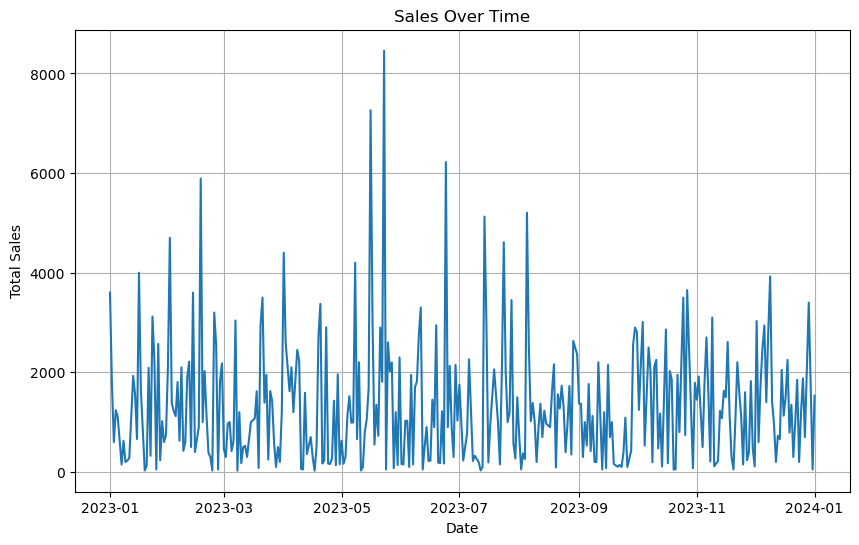

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(daily_sales['Date'], daily_sales['Total Amount'])
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


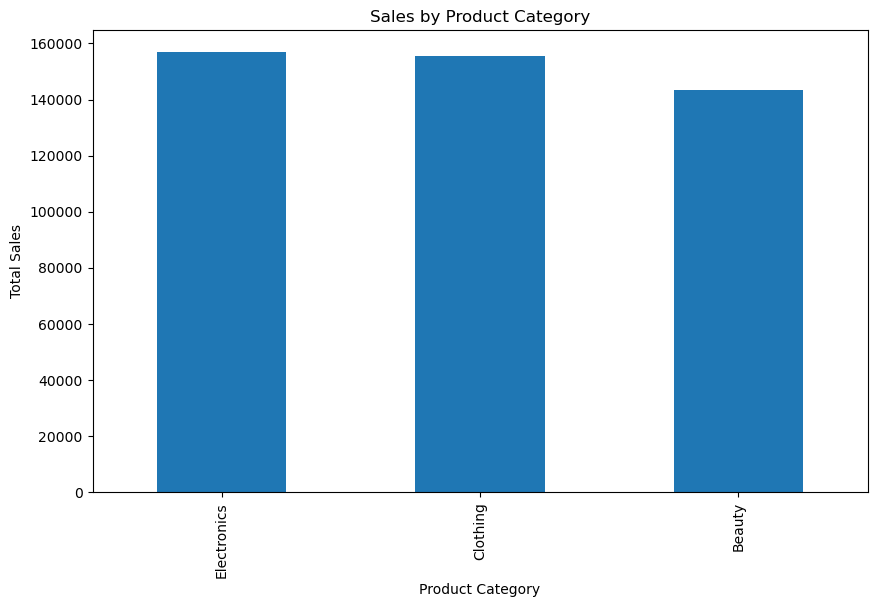

In [19]:
plt.figure(figsize=(10, 6))
category_sales.plot(kind='bar')
plt.title('Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Sales')
plt.show()


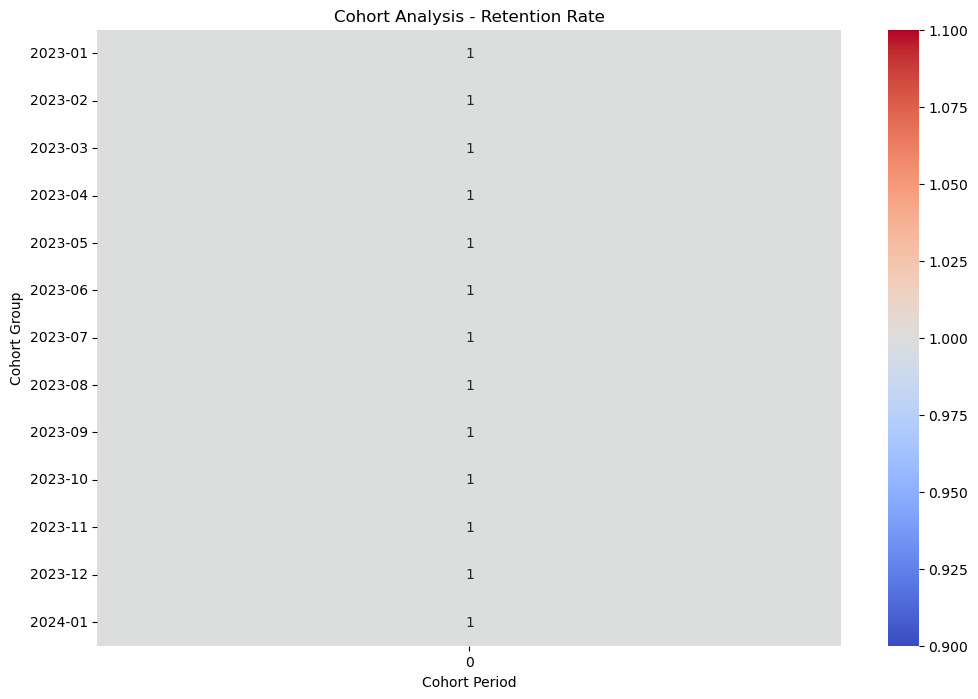

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(retention_rate, annot=True, cmap='coolwarm')
plt.title('Cohort Analysis - Retention Rate')
plt.ylabel('Cohort Group')
plt.xlabel('Cohort Period')
plt.show()


23:30:47 - cmdstanpy - INFO - Chain [1] start processing


          ds     y
0 2023-01-01  3600
1 2023-01-02  1765
2 2023-01-03   600
3 2023-01-04  1240
4 2023-01-05  1100
Index(['ds', 'y'], dtype='object')


23:30:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Verma\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Verma\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


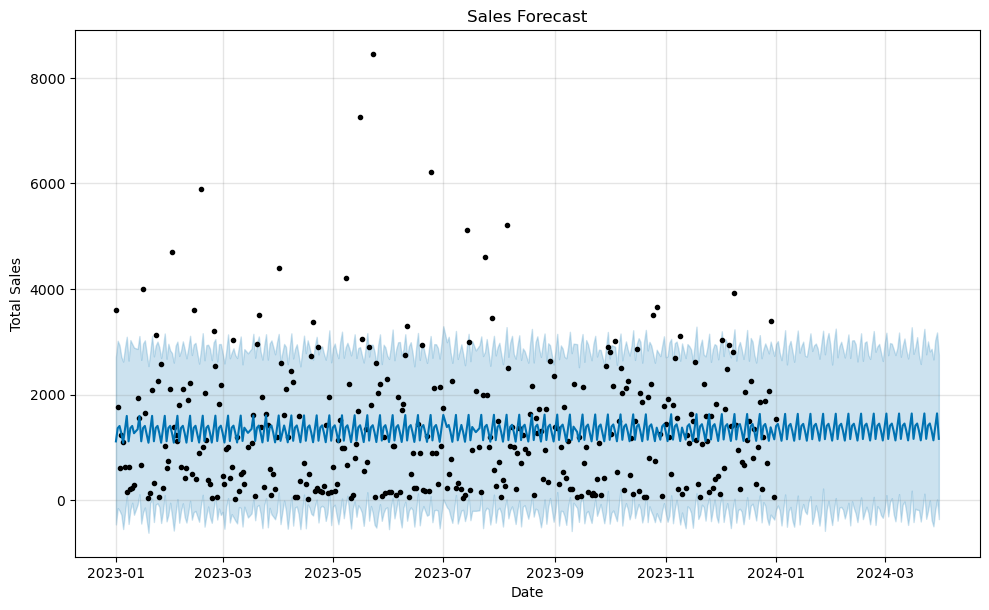

In [38]:

from prophet import Prophet

daily_sales = data.groupby('Date')['Total Amount'].sum().reset_index()

# Rename columns for Prophet
prophet_data = daily_sales.rename(columns={'Date': 'ds', 'Total Amount': 'y'})

# Verify the data
print(prophet_data.head())
print(prophet_data.columns)

# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(prophet_data)

# Create future dates for prediction
future = model.make_future_dataframe(periods=90)

# Predict future sales
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()